# May 31st, 2021

**Motivation**: Explore Ca data in common space. </br>

In [1]:
# HIDE CODE


import re
import os
import sys
import ants
import functools
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

## Load data

$Ca^{2+}$ in common space.  There are 10 animals, 3 sessions, and 7 runs per session.  Here I load $Ca^{2+}$ data from and a randomly selected run for each session and animal.  The data are aligned across runs, so these will be represntative of that session/animal.

In [2]:
# HIDE CODE


config = Config()

mode = 'ca2'
space = 'common'

# ca = {}
masks = {}
for subject in tqdm(range(1, config.num_subjects+1), leave=False):
    for session in tqdm(range(1, config.num_sessions+1), leave=False):
        keywords = [
            'sub-SLC{:02d}'.format(subject),
            'ses-{:d}'.format(session),
            'space-{:s}'.format(space),
            'task-rest',
            'ca',
        ]
        gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in keywords))
        ca_file = next(gen)
        file = pjoin(config.raw_dir, ca_file)

        try:
            _ca = nib.load(file).get_fdata().squeeze()
        except FileNotFoundError:
            print('Warning! File not found, moving on . . .\n{}\n'.format(ca_file))
            continue

        key = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(session)])
        masks[key] = np.abs(_ca).mean(-1) > 0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
masks.keys()

dict_keys(['sub-SLC01_ses-1', 'sub-SLC01_ses-2', 'sub-SLC01_ses-3', 'sub-SLC02_ses-1', 'sub-SLC02_ses-2', 'sub-SLC02_ses-3', 'sub-SLC03_ses-1', 'sub-SLC03_ses-2', 'sub-SLC03_ses-3', 'sub-SLC04_ses-1', 'sub-SLC04_ses-2', 'sub-SLC04_ses-3', 'sub-SLC05_ses-1', 'sub-SLC05_ses-2', 'sub-SLC05_ses-3', 'sub-SLC06_ses-1', 'sub-SLC06_ses-2', 'sub-SLC06_ses-3', 'sub-SLC07_ses-1', 'sub-SLC07_ses-2', 'sub-SLC07_ses-3', 'sub-SLC08_ses-1', 'sub-SLC08_ses-2', 'sub-SLC08_ses-3', 'sub-SLC09_ses-1', 'sub-SLC09_ses-2', 'sub-SLC09_ses-3', 'sub-SLC10_ses-1', 'sub-SLC10_ses-2', 'sub-SLC10_ses-3'])

### Plot time series (sub-SLC06)

First let's take a look at time series data

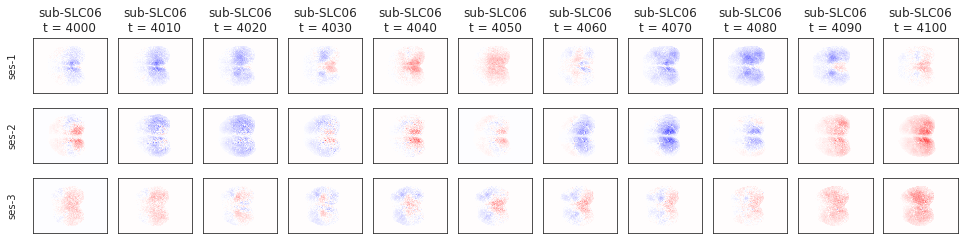

In [4]:
# HIDE CODE


subject = 6
start = 4000

sns.set_style('white')
nrows, ncols = config.num_sessions, 11
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 3.6))
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)

for session in range(1, config.num_sessions+1):
    i = session - 1
    keywords = [
        'sub-SLC{:02d}'.format(subject),
        'ses-{:d}'.format(session),
        'space-{:s}'.format(space),
        'task-rest',
        'ca',
    ]
    gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in keywords))
    ca_file = next(gen)
    file = pjoin(config.raw_dir, ca_file)
    _ca = nib.load(file).get_fdata().squeeze()
    vminmax = np.max(np.abs(_ca))
    
    for j, t in enumerate(range(start, start + 10 * ncols, 10)):
        data2plt = _ca[..., t]
        axes[i, j].imshow(data2plt, interpolation='none', cmap='seismic', vmin=-vminmax, vmax=vminmax)
        # list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        if i == 0:
            axes[i, j].set_title('sub-SLC{:02d}\nt = {:d}'.format(subject, t))
        if j == 0:
            axes[i, j].set_ylabel('ses-{:d}\n'.format(session))
fig.tight_layout()
fig.savefig('masks_across_sessions.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Plot masks (all animals)

Here I compute a binary mask using time series data:
- 1: for pixels with nonzero activation
- 0: for pixels in the boundary

The masks are defined as follows:

```Python
# suppose ca is the time series data
# ca has shape (width x height x time)
mask = np.abs(ca).mean(-1) > 0
# mask has shape (width x height), and is nonzero for pixels with nonzero activation
```

The goal is to compare these masks across sessions and subjects.  I used **Dice coefficient** to quantify the mismatch.

#### First, let's compare session 1 to other sessions, same animal

In [5]:
def dice_score(m1, m2):
    return 2.0 * np.logical_and(m1 == 1, m2 == 1).sum() / (np.sum(m1) + np.sum(m2))

def overlap_score(m1, m2):
    return np.logical_and(m1 == 1, m2 == 1).sum() / min(np.sum(m1), np.sum(m2))

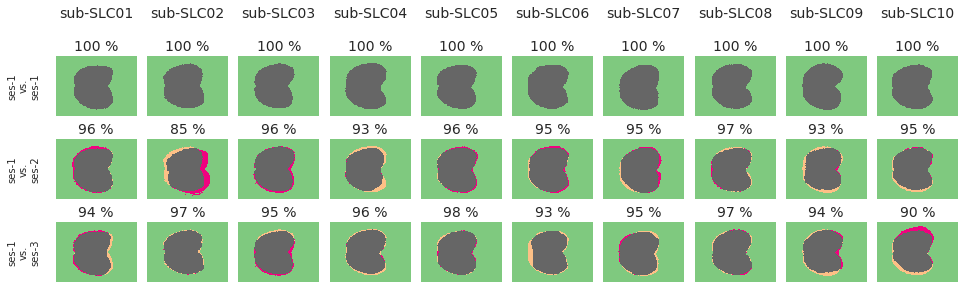

In [6]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = config.num_sessions, config.num_subjects
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4.2))
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)

for subject in range(1, config.num_subjects+1):
    key0 = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(1)])
    m0 = masks[key0]
    for session in range(1, config.num_sessions+1):
        key1 = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(session)])
        m1 = masks[key1]
        
        i, j = session-1, subject-1

        data2plt = m0.astype(float) + 2 * m1.astype(float)
        axes[i, j].imshow(data2plt, interpolation='none', cmap='Accent')
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        # title = '{:.0f} {:s}'.format(overlap_score(m0, m1) * 100, '%')
        title = '{:.0f} {:s}'.format(dice_score(m0, m1) * 100, '%')
        if i == 0:
            title = 'sub-SLC{:02d}\n\n'.format(subject) + title
        axes[i, j].set_title(title, fontsize=14)
        if j == 0:
            axes[i, j].set_ylabel('ses-1\nvs.\nses-{:d}\n'.format(session))
fig.tight_layout()
fig.savefig('masks_across_sessions.pdf', dpi=300, bbox_inches='tight')
plt.show()

In this figure:
- grey area shows overlap,
- green shows the boundaries, and
- yellow or red indicate non-overlapping areas

We see that sub-SLC02, ses-2 in particular has more non-overlapping pixels.

#### Identify sessions/animal pairs with maximum amount of non-overlap

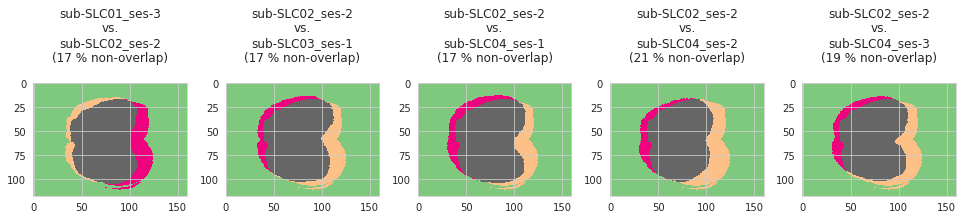

In [7]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 1, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7))

counter = 0
percent_discrepancy = []
for (k1, m1), (k2, m2) in itertools.combinations(masks.items(), r=2):
    _disc = (1 - dice_score(m1, m2)) * 100
    percent_discrepancy.append(_disc)
    
    if _disc > 17 and counter < ncols:
        data2plt = m1.astype(float) + 2 * m2.astype(float)
        axes[counter].imshow(data2plt, interpolation='none', cmap='Accent')
        axes[counter].set_title("{:s}\nvs.\n{:s}\n({:.0f} {:s} non-overlap)\n".format(k1, k2, _disc, '%'))
        counter += 1

fig.tight_layout()
fig.savefig('large_discrepancies.pdf', dpi=100, bbox_inches='tight')
plt.show()

From this figure we see that sub-SLC02 again has more non-overlapping pixels with some others.

#### Histogram of non-overlap percentage

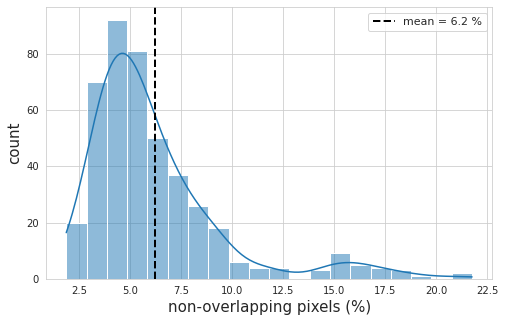

In [8]:
# HIDE CODE


sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.histplot(percent_discrepancy, kde=True, bins=20)
_mean = np.mean(percent_discrepancy)
plt.axvline(_mean, ls='--', color='k', lw=2, label='mean = {:.1f} {:s}'.format(_mean, '%'))
plt.xlabel('non-overlapping pixels (%)', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.legend(fontsize=11)
plt.savefig('discrepancy_hist.pdf', dpi=100, bbox_inches='tight')
plt.show()

This figure is generate by comparing the masks between every possible session/animal pairs.  Masks are computed like explained above:

```Python
# ca is the time series data and has shape (width x height x time)
mask = np.abs(ca).mean(-1) > 0

```

#### Global mask

Here I define a global mask by computing the intersection of all masks across sessions/animals.

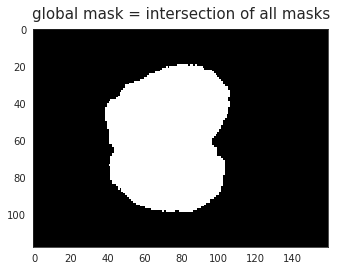

In [9]:
# HIDE CODE


import functools
global_mask = functools.reduce(np.logical_and, masks.values())

sns.set_style('white')
plt.imshow(global_mask, interpolation='none', cmap='Greys_r')
plt.title('global mask = intersection of all masks', fontsize=15, y=1.02)
plt.savefig('global_mask.pdf', dpi=50, bbox_inches='tight')
plt.show()

#### Discrepancies between global mask and individual masks

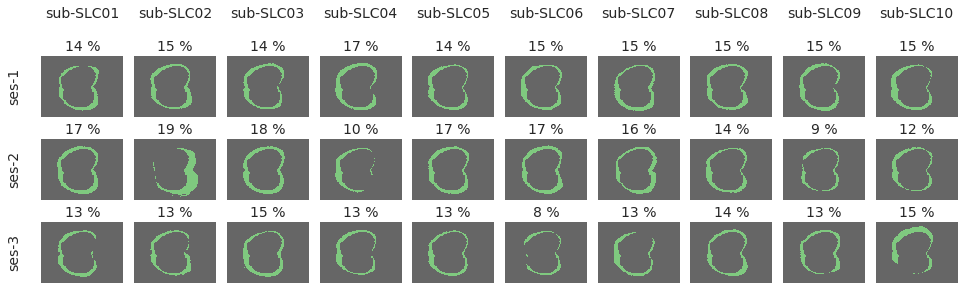

In [10]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = config.num_sessions, config.num_subjects
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4.2))
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)
    
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        i, j = session-1, subject-1
        key = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(session)])
        data2plt = global_mask.astype(float) - masks[key].astype(float)
        axes[i, j].imshow(data2plt, interpolation='none', cmap='Accent')
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if j == 0:
            axes[i, j].set_ylabel('ses-{:d}\n'.format(session), fontsize=14)

        _disc = (1 - dice_score(global_mask, masks[key])) * 100
        title = '{:.0f} {:s}'.format(_disc, '%')
        if i == 0:
            title = 'sub-SLC{:02d}\n\n'.format(subject) + title
        axes[i, j].set_title(title, fontsize=14)

fig.tight_layout()
fig.savefig('masks_vs_global.pdf', dpi=300, bbox_inches='tight')
plt.show()

This figure shows the amount of mismatch between the global mask and individual masks defined for each session/animal.

- The grey area in the middle: global mask
- The green area: discrepancy between global mask and the individual

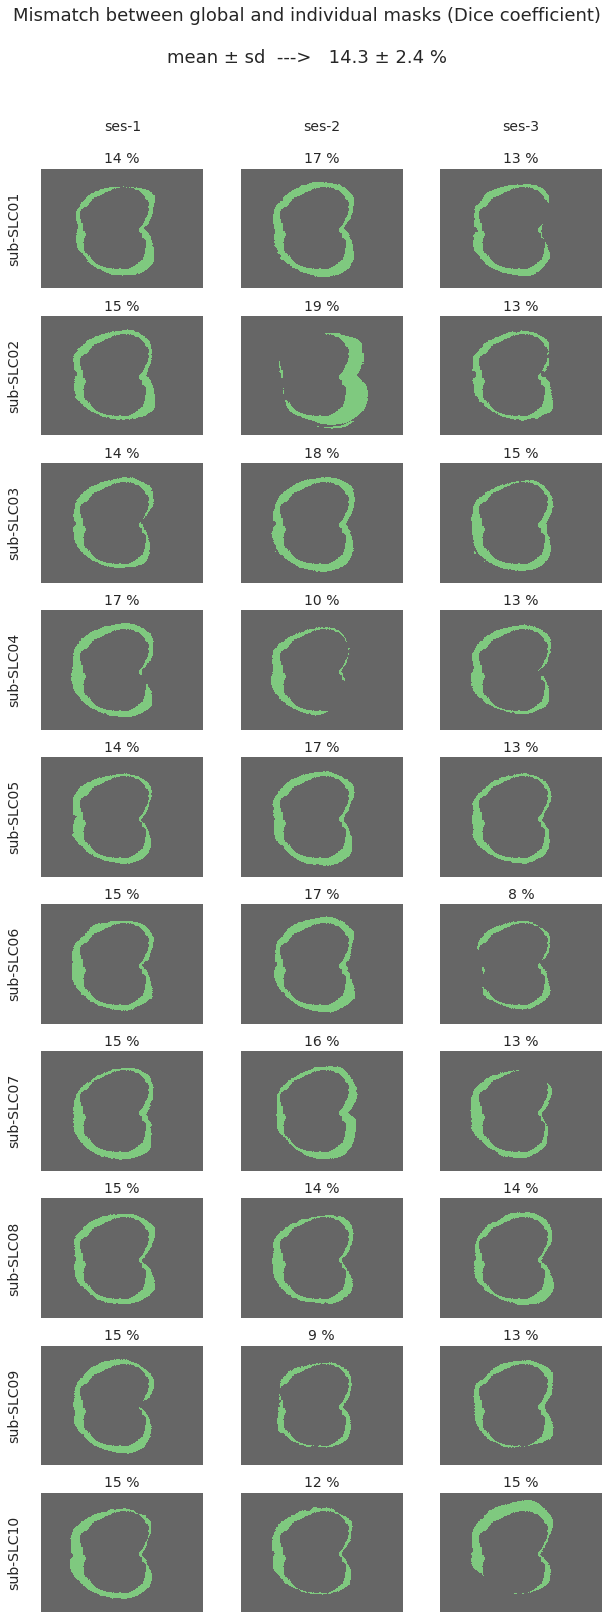

In [11]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = config.num_subjects, config.num_sessions
fig, axes = plt.subplots(nrows, ncols, figsize=(9, 22))
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)
    
global_discrepancies = []
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        j, i = session-1, subject-1
        key = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(session)])
        data2plt = global_mask.astype(float) - masks[key].astype(float)
        axes[i, j].imshow(data2plt, interpolation='none', cmap='Accent')
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        _disc = (1 - dice_score(global_mask, masks[key])) * 100
        global_discrepancies.append(_disc)
        title = '{:.0f} {:s}'.format(_disc, '%')
        if i == 0:
            title = 'ses-{:d}\n\n'.format(session) + title
        axes[i, j].set_title(title, fontsize=14)

        if j == 0:
            axes[i, j].set_ylabel('sub-SLC{:02d}\n'.format(subject), fontsize=14)

msg = 'Mismatch between global and individual masks (Dice coefficient)\n\n'
msg += 'mean ± sd  --->   {:.1f} ± {:.1f} {:s}'
msg = msg.format(np.mean(global_discrepancies), np.std(global_discrepancies), '%')
fig.suptitle(msg, fontsize=18, y=1.02)            
fig.tight_layout()
fig.savefig('masks_vs_global_dice.pdf', dpi=300, bbox_inches='tight')
plt.show()

### With grid

In [12]:
x_range = range(29, 127)
y_range = range(7, 114)
xticks = range(0, len(x_range), 5)
yticks = range(0, len(y_range), 5)
xtick_labels = range(x_range.start, x_range.stop, 5)
ytick_labels = range(y_range.start, y_range.stop, 5)

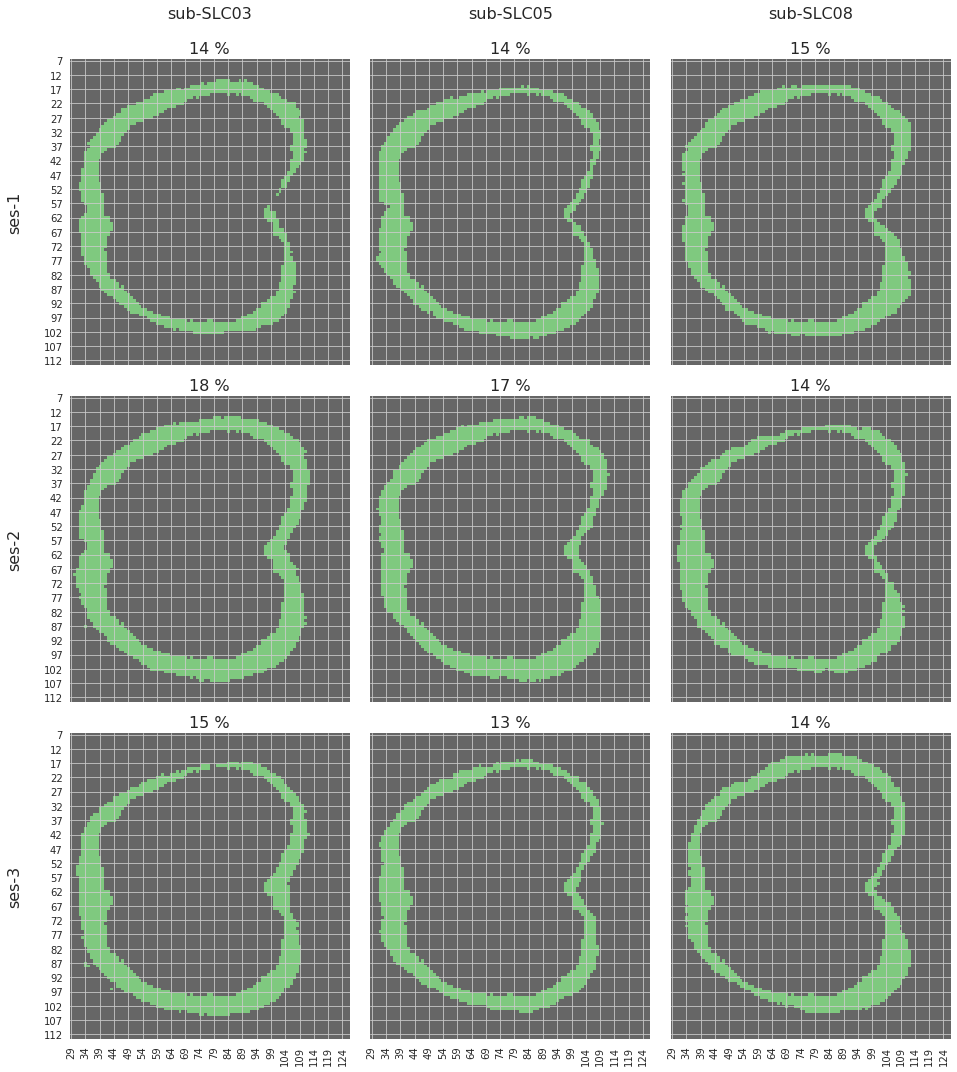

In [13]:
# HIDE CODE


selected_subjects = [3, 5, 8]

sns.set_style('whitegrid')
nrows, ncols = config.num_sessions, len(selected_subjects)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 15), sharex='all', sharey='all')
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)
    
for j, subject in enumerate(selected_subjects):
    for i, session in enumerate(range(1, config.num_sessions+1)):

        key = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(session)])
        data2plt = global_mask.astype(float) - masks[key].astype(float)
        data2plt = data2plt[y_range][:, x_range]
        axes[i, j].imshow(data2plt, interpolation='none', cmap='Accent')
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks(xticks)
        axes[i, j].set_yticks(yticks)
        axes[i, j].set_xticklabels(xtick_labels, rotation=90)
        axes[i, j].set_yticklabels(ytick_labels, rotation=0)
        
        if j == 0:
            axes[i, j].set_ylabel('ses-{:d}\n'.format(session), fontsize=16)

        _disc = (1 - dice_score(global_mask, masks[key])) * 100
        title = '{:.0f} {:s}'.format(_disc, '%')
        if i == 0:
            title = 'sub-SLC{:02d}\n\n'.format(subject) + title
        axes[i, j].set_title(title, fontsize=16)

fig.tight_layout()
fig.savefig('masks_vs_global_grid_1.pdf', dpi=100, bbox_inches='tight')
plt.show()

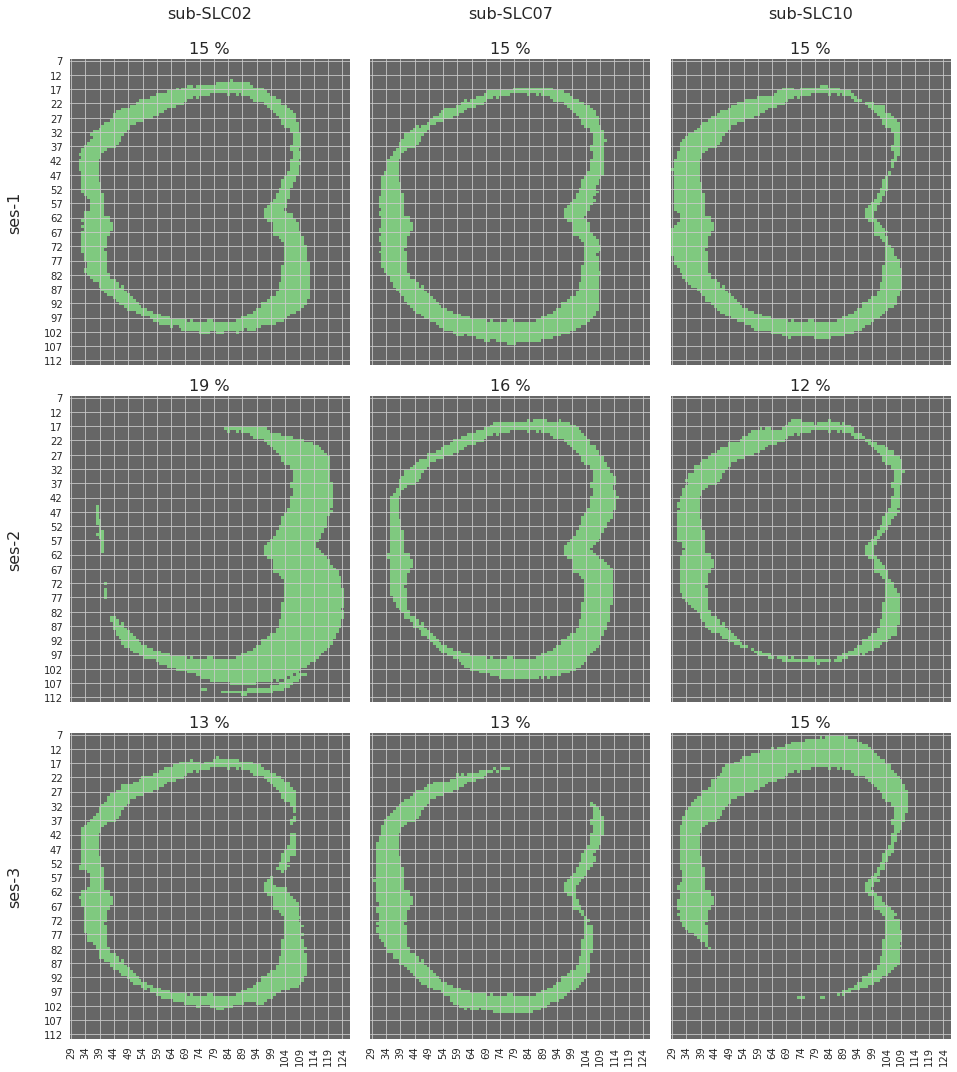

In [14]:
# HIDE CODE


selected_subjects = [2, 7, 10]

sns.set_style('whitegrid')
nrows, ncols = config.num_sessions, len(selected_subjects)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 15), sharex='all', sharey='all')
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)
    
for j, subject in enumerate(selected_subjects):
    for i, session in enumerate(range(1, config.num_sessions+1)):

        key = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(session)])
        data2plt = global_mask.astype(float) - masks[key].astype(float)
        data2plt = data2plt[y_range][:, x_range]
        axes[i, j].imshow(data2plt, interpolation='none', cmap='Accent')
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks(xticks)
        axes[i, j].set_yticks(yticks)
        axes[i, j].set_xticklabels(xtick_labels, rotation=90)
        axes[i, j].set_yticklabels(ytick_labels, rotation=0)
        
        if j == 0:
            axes[i, j].set_ylabel('ses-{:d}\n'.format(session), fontsize=16)

        _disc = (1 - dice_score(global_mask, masks[key])) * 100
        title = '{:.0f} {:s}'.format(_disc, '%')
        if i == 0:
            title = 'sub-SLC{:02d}\n\n'.format(subject) + title
        axes[i, j].set_title(title, fontsize=16)

fig.tight_layout()
fig.savefig('masks_vs_global_grid_2.pdf', dpi=100, bbox_inches='tight')
plt.show()

## Reference images

In [15]:
# HIDE CODE


from skimage.measure import block_reduce

config = Config()

refs = {}
masks = {}
for subject in tqdm(range(1, config.num_subjects+1), leave=False):
    for session in tqdm(range(1, config.num_sessions+1), leave=False):

        keywords = [
            'sub-SLC{:02d}'.format(subject),
            'ses-{:d}'.format(session),
            'space-individual',
            'ca',
        ]

        # mask
        kws_mask = keywords + ['desc-mask']
        gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_mask))
        mask_file = pjoin(config.raw_dir, next(gen))
        
        # ref
        kws_ref = keywords + ['desc-referenceimage']
        gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_ref))
        ref_file = pjoin(config.raw_dir, next(gen))
        
        # load anat and mask and reorient
        ref = nib.load(ref_file).get_fdata().squeeze()
        mask = nib.load(mask_file).get_fdata().squeeze()
        
        block_size = tuple(i//j for i, j in zip(ref.shape, mask.shape))
        ref = block_reduce(ref, block_size=block_size, func=np.mean)
        ref *= mask
        
        key = '_'.join(keywords[:2])
        refs[key] = ref
        masks[key] = mask

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

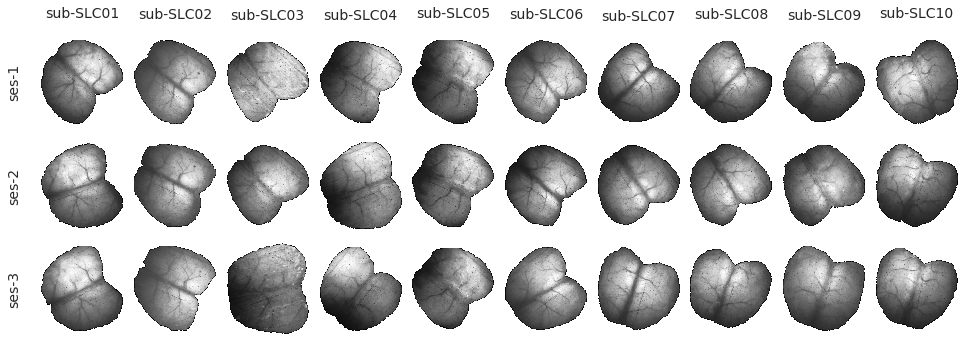

In [16]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = config.num_sessions, config.num_subjects
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 5.))
if len(axes.shape) != 2:
    axes = axes.reshape(nrows, ncols)
    
for j, subject in enumerate(range(1, config.num_subjects+1)):
    for i, session in enumerate(range(1, config.num_sessions+1)):
        key = '_'.join(['sub-SLC{:02d}'.format(subject), 'ses-{:d}'.format(session)])
        x = filter_boundaries(refs[key], masks[key])[0]
        data2plt = np.ma.masked_where(x == 0, x)
        axes[i, j].imshow(data2plt, interpolation='none', cmap='Greys_r')
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if j == 0:
            axes[i, j].set_ylabel('ses-{:d}\n'.format(session), fontsize=14)

        if i == 0:
            title = 'sub-SLC{:02d}\n'.format(subject)
            axes[i, j].set_title(title, fontsize=14)

fig.tight_layout()
fig.savefig('reference_spaces.pdf', dpi=300, bbox_inches='tight')
plt.show()